In [2]:
# Extract song info from html
import requests
import requests_cache
requests_cache.install_cache("cache")
from bs4 import BeautifulSoup
billboard_url = "http://www.billboard.com/articles/list/2155531/the-hot-100-all-time-top-songs"
soup = BeautifulSoup((requests.get(billboard_url)).text, "html.parser")
songs = [song.text for song in soup.find_all("h3", {"class": "list-data__title"})]

# Extra title, artist, and year info
import re
# We consider only the first year for a song if more than one: the 100th song's case
titles  = [str(re.sub(r"\xe2\x80\xa6", r"...", re.sub("\"", "", re.match(r"\"[\"\']?.+\"[\"\']?", song).group(0)))) for song in songs]
artists = [str(re.sub("^\"|\r|(- )|(.*\".*\" )","", re.search("\" .*\r", song).group(0)).lstrip()) for song in songs]
years   = [int(re.sub("\)|\(|,", "", re.search("(\(\d{4}\))|(\(\d{4},)", song).group(0))) for song in songs]

import pandas as pd 
top100songs = pd.DataFrame({'Title': titles, 'Artist': artists, 'Year': years})

In [3]:
import re
import string
import pandas as pd
test = top100songs.loc[9] 
def processString(s, type):
    s = re.sub("['?:!.,;&/]+", " ", s).lower().strip()
    if(type != "Artist"):
        s = re.sub("-", "",s)
    s = re.sub("\s+", "-", s)
    return(s)

def getLyrics(song, newUrl = ''):
    artist = song['Artist']
    title = song['Title']
    #Remove punctuation and change to lower case.
    artist = processString(artist, "Artist")
    title = processString(title," Title")
    lyric_url = "http://www.songlyrics.com/"+artist+"/"+title+"-lyrics/"
    if newUrl != '':
        lyric_url = newUrl
#    print(lyric_url)
    soup = BeautifulSoup((requests.get(lyric_url)).text, "html.parser")
    tmp = soup.find_all('p', {"id": "songLyricsDiv"})
    lyrics = tmp[0].get_text().encode("ascii","ignore")
    if bool(re.search(pattern= "(We do not have)|(we have no)", string = lyrics)):
        lyrics = ""
        lyric_url = ""
    return({'Url':lyric_url, 'Lyric': lyrics})


In [3]:
getLyrics(top100songs.loc[80])
top100songs.loc[80]

Artist                        Percy Faith
Title     The Theme from 'A Summer Place'
Year                                 1960
Name: 80, dtype: object

In [4]:
result = [getLyrics(row) for idx, row in top100songs.iterrows()]
result = pd.DataFrame(result)

In [5]:
#Locate songs that couldn't be found using function
missing =result[result['Url'] == ""].index
top100songs.loc[missing]

,Artist,Title,Year
53,Elton John,Candle in the Wind 1997 / Something About the ...,1997
60,Paul McCartney and Michael Jackson,"Say, Say, Say",1983
80,Percy Faith,The Theme from 'A Summer Place',1960
83,Jewel,You Were Meant for Me / Foolish Games,1997


In [5]:
notFoundUrls = ["http://www.songlyrics.com/elton-john-billy-joel/candle-in-the-wind-lyrics/", "http://www.songlyrics.com/percy-faith/theme-from-a-summer-place-lyrics/","http://www.songlyrics.com/jewel-feat-kelly-clarkson/foolish-games-lyrics/", ""]

In [6]:
result.loc[53,'Lyric':'Url'] = getLyrics(top100songs.loc[53], newUrl = notFoundUrls[0])
result.loc[80,'Lyric':'Url'] = getLyrics(top100songs.loc[80], newUrl = notFoundUrls[1])
result.loc[83,'Lyric':'Url'] = getLyrics(top100songs.loc[83], newUrl = notFoundUrls[2])

In [7]:
song = top100songs.loc[60]
artist = song['Artist']
title = song['Title']
lyric_url = "http://www.metrolyrics.com/say-say-say-lyrics-paul-mccartney.html"
artist = processString(artist, "Artist")
title = processString(title," Title")
soup = BeautifulSoup((requests.get(lyric_url)).text, "html.parser")
tmp = soup.find_all('div', {"id": "lyrics-body-text"})
lyrics = tmp[0].get_text().encode("ascii","ignore")
result.loc[60,'Lyric': 'Url'] = {'Lyric': lyrics, 'Url': lyric_url}

<p>
<h1>Cindy's Analysis Time!! :D</h1>

In [8]:
main_df = pd.concat([top100songs,result], axis = 1)
main_df["Rank"] = range(100, 0, -1)
del main_df["Url"]
main_df.head()

,Artist,Title,Year,Lyric,Rank
0,Usher,You Make Me Wanna...,1997,This is what you do\nThis is what you do\nThis...,100
1,fun. feat. Janelle Monae,We Are Young,2012,"Give me a second, I\nI need to get my story st...",99
2,Emotions,Best of My Love,1977,Every night I'm lyin' in bed\nHoldin' you clos...,98
3,Maroon 5,One More Night,2012,You and I go hard at each other like we're goi...,97
4,Phil Collins,Another Day in Paradise,1989,"She calls out to the man on the street\n""Sir, ...",96


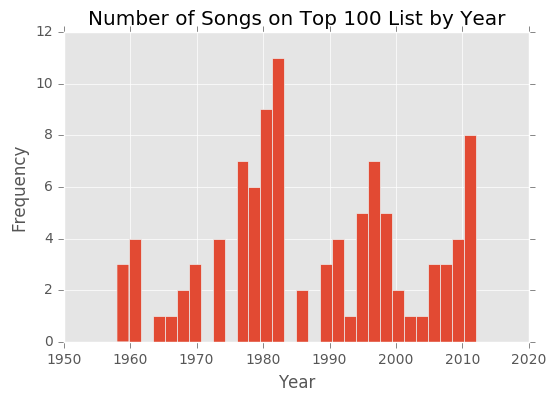

In [9]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.hist(main_df["Year"], bins = 30)
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.title("Number of Songs on Top 100 List by Year")
plt.show()

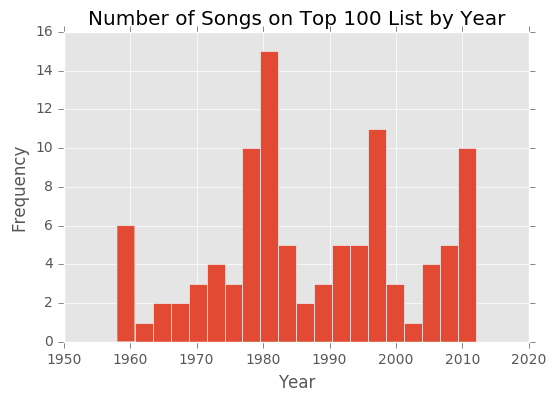

In [10]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.hist(main_df["Year"], bins = 20)
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.title("Number of Songs on Top 100 List by Year")
plt.show()

In [12]:
max(main_df["Year"]), min(main_df["Year"])

(2012, 1958)

From the histogram, we can see there were quite a lot of top hits right when the first official 'blended' billboard began in 1958. After there, it is not until the late 1970's that music really picks up again. The all-time peak is in that time frame (late 1970s to early 1980s).
<p>After that, there is a dip with normal amounts of top hits until the late 1990s, with another spike. This spike is soon followed by a big dip, which picks up again in the in the later half of the 2000s.
<p>We can see that the 2010's are starting strong with lots of top hits coming out.

<i>Some questions to think about:
* Could the peak in the 2010s be attributed to the fact that music was much more easily distributed at that time? Is this Billboard chart a good measure of popularity?
* Are we able to pinpoint major trends and music phases?
* Are the frequencies also in line with the song's absolute performance on the chart?
* Why were there not that many hits in the early 2000s? Was this just a simple music low, was it due to external factors, or was it simply because one song hit the charts for a long time?
* What were the songs and rankings from the late 1970s-early 1980s?

<i>Note: The first question is simply to add a bit of skepticism and will not be explored in this project.</i>

In [13]:
peak_70_80 = main_df[(main_df["Year"] > 1975) & (main_df["Year"] < 1984)].sort_values(by="Rank")
peak_70_80.head()

,Artist,Title,Year,Lyric,Rank
92,Olivia Newton-John,Physical,1981,I'm saying all the things that I know you'll l...,8
91,Debby Boone,You Light Up My Life,1977,So many nights I'd sit by my window\nWaiting f...,9
86,Kim Carnes,Bette Davis Eyes,1981,Her hair is Harlow gold\nHer lips sweet surpri...,14
85,Diana Ross & Lionel Richie,Endless Love,1981,My love\nThere's only you in my life\nThe only...,15
84,Rod Stewart,Tonight's the Night (Gonna Be Alright),1976,Stay away from my window\nStay away from my ba...,16


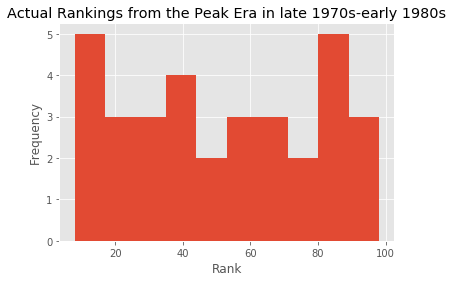

In [14]:
plt.hist(peak_70_80["Rank"], bins = 10)
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.title("Actual Rankings from the Peak Era in late 1970s-early 1980s")
plt.show()

This answers the last question. We can see that there is not a noticeable skew in the data. This could mean that yes, there were a lot of all-time popular songs during these eras, and these songs performed typically like how the rest of the distribution, with roughly even numbers throughout. We <b>cannot</b> say that 
* <i>Hypothesis 1:</i> The songs from this era had high quantity but had very mediocre/lower ranked songs (quantity > quality), nor the opposite --
* <i>Hypothesis 2:</i> America went through a music revolution and released a bunch of top hit singles of all time during this period.

<h2>Frequencies and Popularities</h2>
<p>Now I will try to create a modified plot to capture frequencies, balanced with the Billboard rank performance.

In [11]:
freqs = main_df["Year"].value_counts()
freqs.head()

1982    6
1980    5
1983    5
1997    5
2012    4
Name: Year, dtype: int64

In [13]:
import numpy as np

rank_boost = np.arange(1, 101)
rank_boost = rank_boost * 0.10

In [14]:
frq_df = pd.concat([main_df["Year"], pd.Series(rank_boost)], axis = 1)
frq_df.head()

,Year,0
0,1997,0.1
1,2012,0.2
2,1977,0.3
3,2012,0.4
4,1989,0.5


In [21]:
unique_years = frq_df["Year"].unique()
sum_boosts = {}

for year in frq_df["Year"].unique():
    entries = frq_df[frq_df["Year"] == year]
    sum_boosts[year] = sum(entries.iloc[:,1])

boost = pd.DataFrame(sum_boosts.items(), columns=['Year', 'Boost Value'])

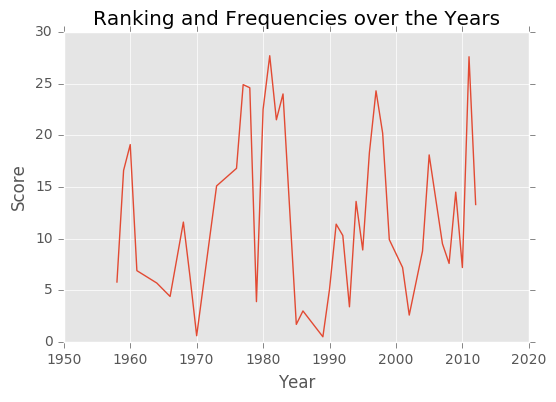

In [22]:
plt.plot(boost["Year"], boost["Boost Value"], '-')
plt.xlabel("Year")
plt.ylabel("Score")
plt.title("Ranking and Frequencies over the Years")
plt.savefig('rankingNfrequency.jpg')
plt.show()

In [35]:
boost.iloc[0:108,0].mean()

1986.780487804878

In [42]:
boost.head()

,Year,Boost Value
0,1958,5.8
1,1959,16.6
2,1960,19.1
3,1961,6.9
4,1964,5.7


In [66]:
avg_years = []
scores = []
for i in range(0, 41):
    avg_years.append(boost.iloc[(i):(i + 4),0].mean())
    scores.append(boost.iloc[(i):(i + 4),1].mean())
scores[0:5]

five_year = pd.DataFrame({'Year':avg_years, 'score':scores})#.sort_values(by = "score", ascending = False)
five_year.head()

,Year,score
0,1959.50,12.100
1,1961.00,12.075
2,1962.75,9.025
3,1964.75,7.150
4,1966.75,7.000


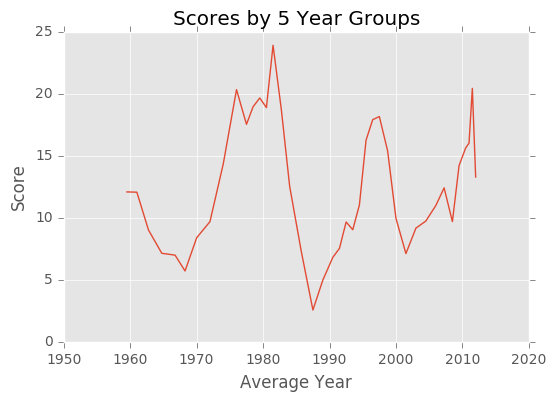

In [68]:
plt.plot(five_year["Year"], five_year["score"], '-')
plt.xlabel("Average Year")
plt.ylabel("Score")
plt.title("Scores by 5 Year Groups")
plt.savefig('rankingNfrequency_5year.jpg')
plt.show()

Now instead of looking at "peak years", I will look to see if an era was good over periods of 5 years. I average out the boosted scores over 5 year time periods.<br>
We can see that now the results are somewhat in between the 1st histogram and the 2nd boosted years line plot. **Early 1980s** really stand out here, and we can see that the high score period lasts for around 5 years. This may be the music "Golden Era" for our data. 2011 appears more like a peak year now (as opposed to an 'era'), and the later 1990s may be interesting to look into as well.